In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os.path
from pathlib import Path

import json
import pyam
import scmdata
import pandas as pd
import numpy as np
from pymagicc.io import MAGICCData

import utils

## plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
def add_peak_warming(df):
    empty_df = pd.DataFrame()
    for ms in df["ms"].unique():
        ms_df = df[df["ms"] == ms]
        for em in ms_df["ensemble_member"].unique():
            em_df = ms_df[ms_df["ensemble_member"] == em]
            peak_warming = em_df[em_df["variable"] == "Surface Air Temperature Change"][
                "peak_value"
            ].item()
            em_df["peak_warming"] = peak_warming

            empty_df = empty_df.append(em_df)
    return empty_df


def add_SRM_length(df):
    empty_df = pd.DataFrame()
    for ms in df["ms"].unique():
        ms_df = df[df["ms"] == ms]
        for em in ms_df["ensemble_member"].unique():
            em_df = ms_df[ms_df["ensemble_member"] == em]
            em_df_delta_rf = em_df[em_df["variable"] == "delta_rf"]
            SRM_years = np.sum(
                em_df_delta_rf.loc[:, range(2030, 2500 + 1)] > 0,
                axis=1,
            ).item()
            em_df["SRM_years"] = SRM_years

            empty_df = empty_df.append(em_df)
    return empty_df

<IPython.core.display.Javascript object>

### Subtracting the extended scenario ERF from the goal 1.5°C-trajectory for each ensemble member


In [4]:
# number of scenarios
NR_SCEN = 200

<IPython.core.display.Javascript object>

In [5]:
SRM_START_YEAR = 2030
ENSEMBLE = list(range(0, 600 + 1))
YEARS = range(1750, 2500 + 1)
ID = "small_selection"
VAR = "ERF"

SCENARIOS_min = [0, 101, 201]
SCENARIOS_max = [100, 200, 300]

SCENARIOS_min = [0, 10, 51, 101, 151]
SCENARIOS_max = [9, 50, 100, 150, 200]

<IPython.core.display.Javascript object>

In [6]:
OUTPUT_FILE = Path(utils.DATA_DIR / "interim" / "delta_rf" / f"{ID}_delta_set0.csv")

<IPython.core.display.Javascript object>

### Load in data
1. Extended scenario
2. 1.5°C-trajectories

In [7]:
# Extended scneario data
datasets = []

for min_, max_ in zip(SCENARIOS_min, SCENARIOS_max):
    DATA_FILE = Path(
        utils.DATA_DIR
        / "interim"
        / "magicc-output"
        / f"magicc-output_{ID}_{min_}_{max_}_totalCDR.csv"
    )
    datasets.append(scmdata.ScmRun(str(DATA_FILE)))
# data_scen = datasets[0].append(datasets[1])
# data_scen = data_scen.append(datasets[2])
data_scen = datasets[0]
data_scen["ms"] = data_scen["model"] + data_scen["scenario"]
ms_list = data_scen.get_unique_meta("ms")

<IPython.core.display.Javascript object>

In [8]:
# use only a few scenarios and drop empty column
data_scen_sel = data_scen.filter(ms=ms_list[:NR_SCEN]).drop_meta("Unnamed: 0")
# use only a few ensemble_members
data_scen_sel = data_scen_sel.filter(ensemble_member=ENSEMBLE)

<IPython.core.display.Javascript object>

In [9]:
# 1.5C trajectories

MEMBERS_FILE = Path(
    utils.DATA_DIR
    / "interim"
    / "merged_15_trajectories"
    / f"merged_{VAR}_{SRM_START_YEAR}.csv"
)

RF_15 = scmdata.ScmRun(str(MEMBERS_FILE))
RF_15 = RF_15.drop_meta("RUNNAME")
RF_15 = RF_15.drop_meta("iteration")

<IPython.core.display.Javascript object>

### Subtraction

In [13]:
scenario_erf_ts = data_scen_sel.filter(variable="*Forcing*", region="World").timeseries(
    ["ensemble_member", "variable", "unit", "ms", "region"], time_axis="year"
)
RF_15_ts = RF_15.filter(region="World").timeseries(
    ["ensemble_member", "variable", "unit", "region", "TCRE"], time_axis="year"
)
# rounding doesn't help for assertion error
# RF_15_ts = RF_15_ts.round(3)

delta_rf_ts = scenario_erf_ts.subtract(RF_15_ts[0 : ENSEMBLE[-1]], axis=0)
delta_rf_ts = delta_rf_ts.reset_index("variable")
delta_rf_ts["variable"] = "delta_rf"
delta_rf_ts = delta_rf_ts.set_index("variable", append=True)

# check that the delta is zero up to 2015
# assert delta_rf_ts.loc[:, 1750:2015].max(axis=1).max() == 0
assert np.abs(delta_rf_ts.loc[:, 1750:2015].max(axis=1).max()) < 1e-2
display(delta_rf_ts.loc[:, 1750:2010].max(axis=1))

# add metadata back in
delta_rf_ts = delta_rf_ts.reset_index().set_index(["ms", "ensemble_member"])
meta_to_add = data_scen_sel.filter(
    ms=delta_rf_ts.index.get_level_values("ms").unique().tolist()
).meta.set_index(delta_rf_ts.index.names)
meta_to_add = meta_to_add[
    [c for c in meta_to_add if c not in delta_rf_ts and c not in ["run_id", "variable"]]
]

meta_to_add = meta_to_add.reset_index().drop_duplicates()
meta_to_add = meta_to_add.set_index(["ms", "ensemble_member"])


delta_rf_ts = delta_rf_ts.join(meta_to_add)
delta_rf_ts = scmdata.ScmRun(delta_rf_ts)

ensemble_member  unit   region  ms                                                        TCRE      variable
0                W/m^2  World   AIM/CGE 2.1CD-LINKS_INDC2030i_1600                        1.950013  delta_rf    0.000498
                                AIM/CGE 2.1CD-LINKS_NDC2030i_1000                         1.950013  delta_rf    0.000498
                                AIM/CGE 2.2EN_INDCi2030_1000f                             1.950013  delta_rf    0.000498
                                AIM/CGE 2.2EN_INDCi2030_1200                              1.950013  delta_rf    0.000498
                                AIM/CGE 2.2EN_INDCi2030_1200f                             1.950013  delta_rf    0.000498
                                                                                                                  ...   
49               W/m^2  World   EPPA 6Paris1.5C_OptTax                                    2.539367  delta_rf    0.000499
                                EPPA 6Paris2

<IPython.core.display.Javascript object>

In [14]:
data_scen_sel = data_scen_sel.append(delta_rf_ts)

NonUniqueMetadataError: Duplicate metadata (numbers show how many times the given metadata is repeated).
                    TCRE climate_model ensemble_member              max_CDR  \
0     0.8749743356706717  MAGICCv7.5.3              25  -10154.794648094809   
1     0.8749743356706717  MAGICCv7.5.3              25  -10380.400790017884   
2     0.8749743356706717  MAGICCv7.5.3              25  -10496.168225405514   
3     0.8749743356706717  MAGICCv7.5.3              25  -11018.748933349558   
4     0.8749743356706717  MAGICCv7.5.3              25   -11050.02551157124   
...                  ...           ...             ...                  ...   
2495  3.4715576812526474  MAGICCv7.5.3               1   -8507.716832942227   
2496  3.4715576812526474  MAGICCv7.5.3               1   -9789.560691082175   
2497  3.4715576812526474  MAGICCv7.5.3               1   -9878.020191816104   
2498  3.4715576812526474  MAGICCv7.5.3               1   -9879.389209122455   
2499  3.4715576812526474  MAGICCv7.5.3               1   24522.822311650867   

            model                                  ms region run_id  \
0      COFFEE 1.1         COFFEE 1.1EN_INDCi2030_1600  World    nan   
1      COFFEE 1.1          COFFEE 1.1EN_INDCi2030_900  World    nan   
2      COFFEE 1.1          COFFEE 1.1EN_INDCi2030_700  World    nan   
3     AIM/CGE 2.1  AIM/CGE 2.1CD-LINKS_INDC2030i_1600  World    nan   
4      COFFEE 1.1        COFFEE 1.1EN_INDCi2030_1800f  World    nan   
...           ...                                 ...    ...    ...   
2495  AIM/CGE 2.2        AIM/CGE 2.2EN_INDCi2030_800f  World    nan   
2496   COFFEE 1.1         COFFEE 1.1EN_INDCi2030_1800  World    nan   
2497   COFFEE 1.1         COFFEE 1.1EN_INDCi2030_600f  World    nan   
2498  AIM/CGE 2.2        AIM/CGE 2.2EN_INDCi2030_1400  World    nan   
2499   COFFEE 1.1     COFFEE 1.1EN_INDCi2100_COV_NDCp  World    nan   

                     scenario            total_CDR      total_CDR_at_15  \
0           EN_INDCi2030_1600    -3922065.83919785                  0.0   
1            EN_INDCi2030_900   -2177753.326815813                  0.0   
2            EN_INDCi2030_700   -3485312.925221085                  0.0   
3     CD-LINKS_INDC2030i_1600   -4566910.366372792   -662683.9676362791   
4          EN_INDCi2030_1800f   -4651990.042490272   -224679.2010037284   
...                       ...                  ...                  ...   
2495        EN_INDCi2030_800f   -3778343.198542746   -1943700.288710843   
2496        EN_INDCi2030_1800   -3996831.792746431  -2728806.2822324927   
2497        EN_INDCi2030_600f   -4415989.382162027   -1774482.972901798   
2498        EN_INDCi2030_1400   -3601997.768464738  -2431541.0834395546   
2499    EN_INDCi2100_COV_NDCp  -153127.17938083524                  1.0   

         total_emissions   unit  variable year_15T  repeats  
0      1388935.184613255  W/m^2  delta_rf     2058        2  
1      770945.1011803069  W/m^2  delta_rf     2050        2  
2     424997.96153734415  W/m^2  delta_rf     2041        2  
3      1271364.083974794  W/m^2  delta_rf     2180        2  
4     1686546.0543593718  W/m^2  delta_rf     2113        2  
...                  ...    ...       ...      ...      ...  
2495   770290.8151695051  W/m^2  delta_rf     2305        2  
2496  1725059.7711473964  W/m^2  delta_rf     2398        2  
2497   693154.9606045766  W/m^2  delta_rf     2234        2  
2498   1271891.193230646  W/m^2  delta_rf     2412        2  
2499   14959126.89069322  W/m^2  delta_rf     2500        2  

[2500 rows x 16 columns]

<IPython.core.display.Javascript object>

### Filter out delta_rf from dataframe, do some work on delta_rf and add it back into the dataframe data_scen_df
#### Read in data as pandas datafame to remove negative values -> import again as scmdata

In [17]:
filtered_delta = data_scen_sel.filter(variable="delta_rf").timeseries(time_axis="year")
data_scen_df = data_scen_sel.filter(variable="delta_rf", keep=False).timeseries(
    time_axis="year"
)
data_scen_df = pd.concat([data_scen_df, filtered_delta.clip(lower=0)])

<IPython.core.display.Javascript object>

### Add TCRE info from delta_rf to the other variables too

In [ ]:
def add_peak_warming(df):
    empty_df = pd.DataFrame()
    for ms in df["ms"].unique():
        ms_df = df[df["ms"] == ms]
        for em in ms_df["ensemble_member"].unique():
            em_df = ms_df[ms_df["ensemble_member"] == em]
            peak_warming = em_df[em_df["variable"] == "Surface Air Temperature Change"][
                "peak_value"
            ].item()
            em_df["peak_warming"] = peak_warming

            empty_df = empty_df.append(em_df)
    return empty_df

## Add peak warming, and SRM years as new columns

In [23]:
# create column with peak values for Temperature and ERF
data_scen_df["peak_value"] = data_scen_df.loc[:, 2030:].max(axis="columns")
data_scen_df = data_scen_df.reset_index()
## add column with peak_warming
df_peak_warming = add_peak_warming(data_scen_df)
## add column with count of SRM years
df_SRM = add_SRM_length(df_peak_warming)
## add TCRE info from delta_rf to the other variables too
for ens in df_SRM['ensemble_member'].unique():
    data_ = df_SRM[df_SRM['ensemble_member'] == ens]
    TCRE_value = data_[data_["variable"] == "delta_rf"][
                "TCRE"
            ][:1].item()
    df_SRM.loc[df_SRM['ensemble_member'] == ens,['TCRE']] = TCRE_value

<IPython.core.display.Javascript object>

## Export file

In [46]:
### df_SRM is the dataframe that's exported to be used for plotting

df_SRM.to_csv(str(OUTPUT_FILE))
delta_scen = scmdata.ScmRun(str(OUTPUT_FILE)).drop_meta("Unnamed: 0")

<IPython.core.display.Javascript object>

# End of notebook

### Plot to check result

/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.reset_index(inplace=True)
/Users/baur/opt/anaconda3/envs/baur-et-al-srm-commitment/lib/python3.9/site-packages/scmdata/run.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

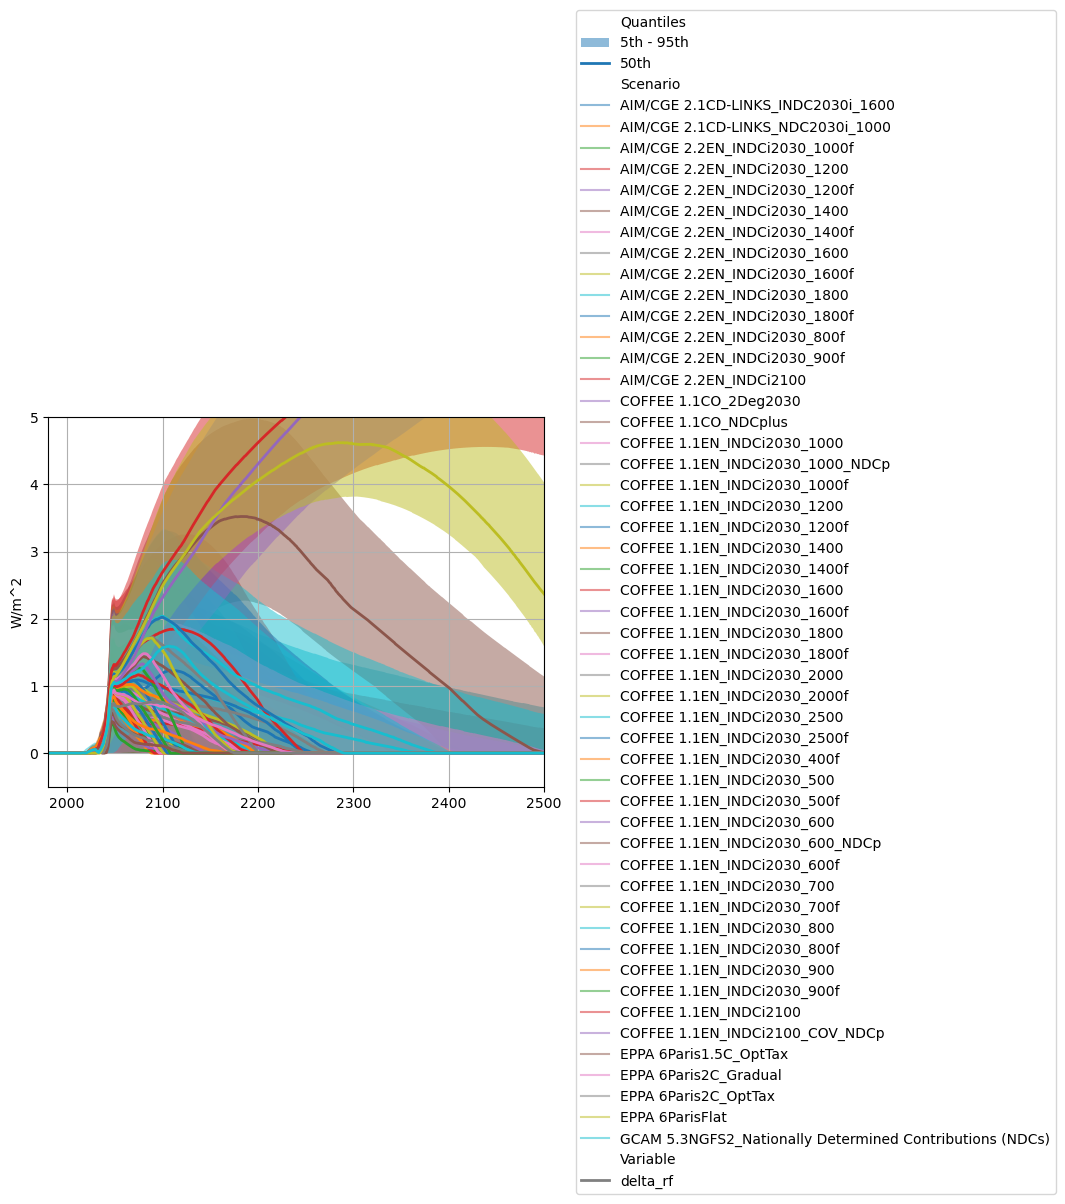

<IPython.core.display.Javascript object>

In [60]:
ax, lh = (
    delta_scen.filter(variable="delta_rf")
    .drop_meta(
        [
            "max_CDR",
            "run_id",
            "total_CDR",
            "total_CDR_at_15",
            "total_emissions",
            "SRM_years",
            "peak_value",
            "peak_warming",
            "year_15T",
            "TCRE",
        ]
    )
    .plumeplot(time_axis="year", hue_var="ms", quantile_over=("ensemble_member",))
)
ax.legend(handles=lh, bbox_to_anchor=(1.05, 0.5), loc="center left")
ax.set_xlim(1980, 2500)
ax.set_ylim(-0.5, 5)
ax.grid()

In [73]:
df_SRM["SRM_years"].min()

0

<IPython.core.display.Javascript object>

In [63]:
srm_years_pdf = df_SRM[["SRM_years", "ms", "ensemble_member"]]

<IPython.core.display.Javascript object>

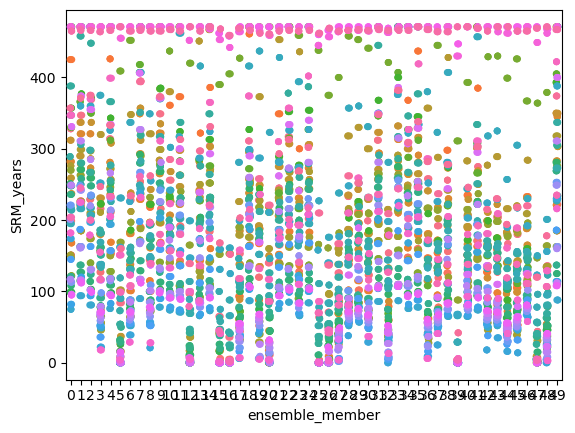

<IPython.core.display.Javascript object>

In [85]:
ax = sns.stripplot(
    data=srm_years_pdf, y="SRM_years", hue="ms", x="ensemble_member", legend=False
)
# ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'AIM/CGE 2.1CD-LINKS_INDC2030i_1600'),
  Text(1, 0, 'AIM/CGE 2.1CD-LINKS_NDC2030i_1000'),
  Text(2, 0, 'AIM/CGE 2.2EN_INDCi2030_1000f'),
  Text(3, 0, 'AIM/CGE 2.2EN_INDCi2030_1200'),
  Text(4, 0, 'AIM/CGE 2.2EN_INDCi2030_1200f'),
  Text(5, 0, 'AIM/CGE 2.2EN_INDCi2030_1400'),
  Text(6, 0, 'AIM/CGE 2.2EN_INDCi2030_1400f'),
  Text(7, 0, 'AIM/CGE 2.2EN_INDCi2030_1600'),
  Text(8, 0, 'AIM/CGE 2.2EN_INDCi2030_1600f'),
  Text(9, 0, 'AIM/CGE 2.2EN_INDCi2030_1800')])

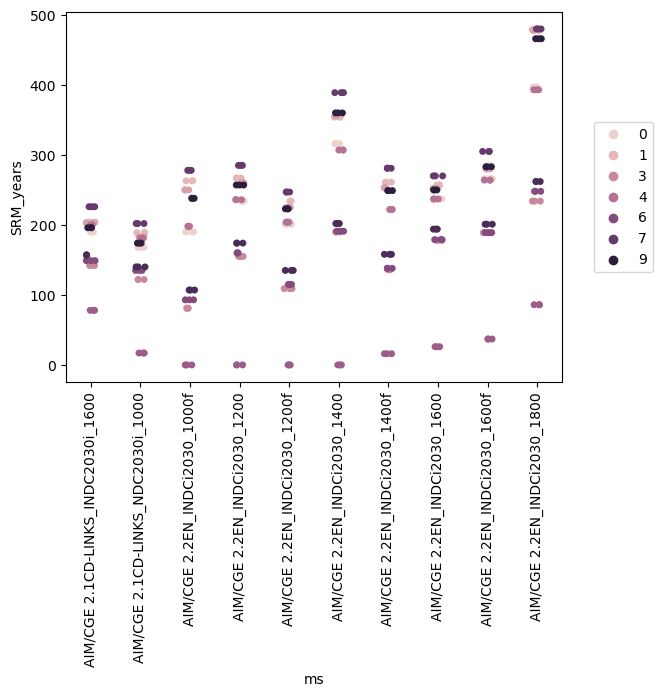

<IPython.core.display.Javascript object>

In [43]:
ax = sns.stripplot(data=srm_years_pdf, y="SRM_years", x="ms", hue="ensemble_member")
ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'AIM/CGE 2.1CD-LINKS_INDC2030i_1600'),
  Text(1, 0, 'AIM/CGE 2.1CD-LINKS_NDC2030i_1000'),
  Text(2, 0, 'AIM/CGE 2.2EN_INDCi2030_1000f'),
  Text(3, 0, 'AIM/CGE 2.2EN_INDCi2030_1200'),
  Text(4, 0, 'AIM/CGE 2.2EN_INDCi2030_1200f'),
  Text(5, 0, 'AIM/CGE 2.2EN_INDCi2030_1400'),
  Text(6, 0, 'AIM/CGE 2.2EN_INDCi2030_1400f'),
  Text(7, 0, 'AIM/CGE 2.2EN_INDCi2030_1600'),
  Text(8, 0, 'AIM/CGE 2.2EN_INDCi2030_1600f'),
  Text(9, 0, 'AIM/CGE 2.2EN_INDCi2030_1800')])

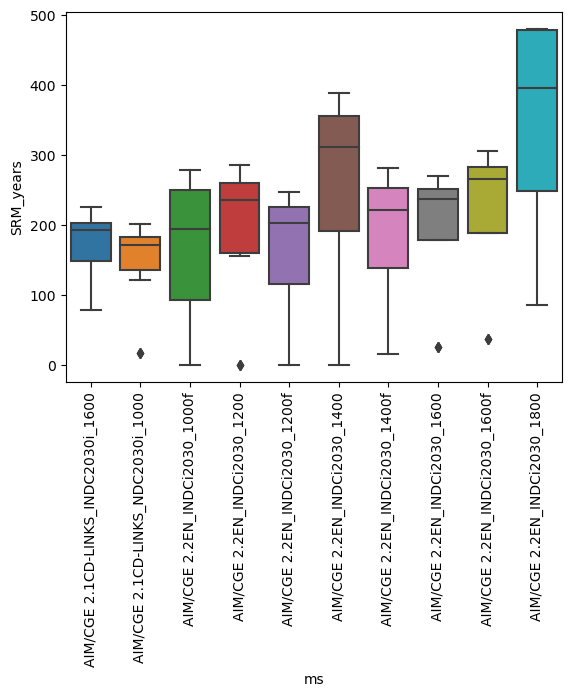

<IPython.core.display.Javascript object>

In [44]:
ax = sns.boxplot(data=srm_years_pdf, y="SRM_years", x="ms")
# ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'AIM/CGE 2.1CD-LINKS_INDC2030i_1600'),
  Text(1, 0, 'AIM/CGE 2.1CD-LINKS_NDC2030i_1000'),
  Text(2, 0, 'AIM/CGE 2.2EN_INDCi2030_1000f'),
  Text(3, 0, 'AIM/CGE 2.2EN_INDCi2030_1200'),
  Text(4, 0, 'AIM/CGE 2.2EN_INDCi2030_1200f'),
  Text(5, 0, 'AIM/CGE 2.2EN_INDCi2030_1400'),
  Text(6, 0, 'AIM/CGE 2.2EN_INDCi2030_1400f'),
  Text(7, 0, 'AIM/CGE 2.2EN_INDCi2030_1600'),
  Text(8, 0, 'AIM/CGE 2.2EN_INDCi2030_1600f'),
  Text(9, 0, 'AIM/CGE 2.2EN_INDCi2030_1800')])

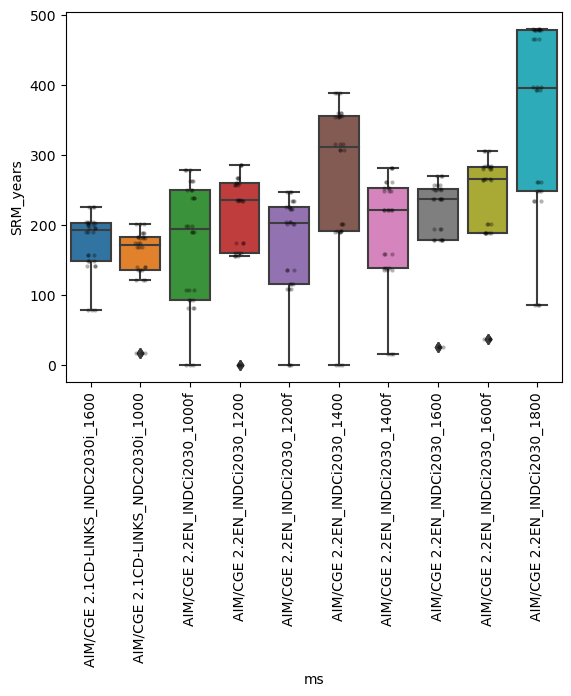

<IPython.core.display.Javascript object>

In [45]:
ax = sns.boxplot(data=srm_years_pdf, y="SRM_years", x="ms")
ax = sns.stripplot(
    data=srm_years_pdf, y="SRM_years", x="ms", ax=ax, alpha=0.3, color="k", size=3
)
# ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")
plt.xticks(rotation=90)

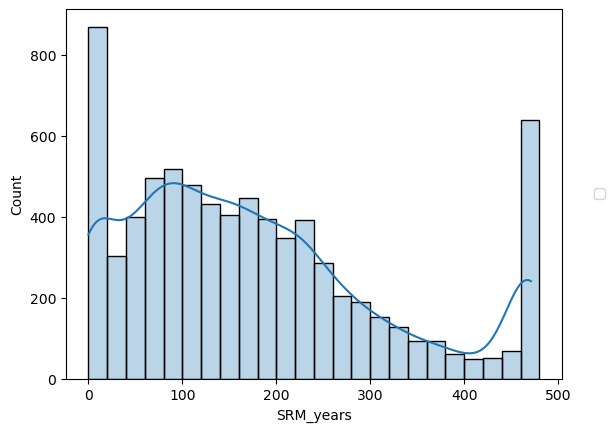

<IPython.core.display.Javascript object>

In [64]:
ax = sns.histplot(
    data=srm_years_pdf,
    x="SRM_years",
    #  hue="ms",
    bins=range(0, 500, 20),
    kde=True,
    #     element="step",
    #     multiple="stack",
    alpha=0.3,
)
ax.legend(bbox_to_anchor=(1.05, 0.5), loc="center left")

(array([918., 408., 489., 645., 573., 507., 507., 486., 435., 459., 345.,
        261., 186., 180., 120., 102.,  81.,  48.,  60., 690.]),
 array([  0.  ,  23.55,  47.1 ,  70.65,  94.2 , 117.75, 141.3 , 164.85,
        188.4 , 211.95, 235.5 , 259.05, 282.6 , 306.15, 329.7 , 353.25,
        376.8 , 400.35, 423.9 , 447.45, 471.  ]),
 <BarContainer object of 20 artists>)

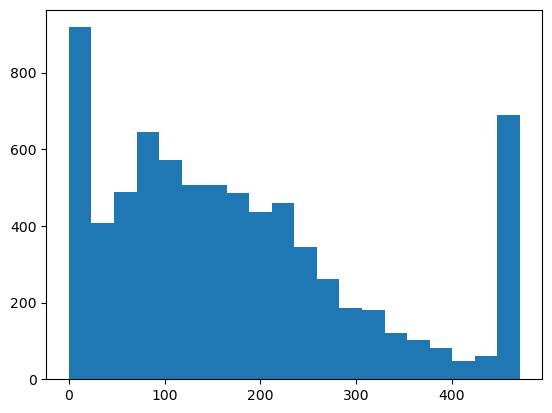

<IPython.core.display.Javascript object>

In [62]:
# histogram with SRM years
plt.hist(df_SRM["SRM_years"], bins=20)